In [6]:
!pip install deap
!pip install sklearn
!pip install xlrd
%matplotlib notebook

  Using cached https://files.pythonhosted.org/packages/b0/16/63576a1a001752e34bf8ea62e367997530dc553b689356b9879339cf45a4/xlrd-1.2.0-py2.py3-none-any.whl


In this tutorial we will use DEAP's Genetic Programming module to build a model that predict the price per area using the[ 'Real estate valuation data set'](https://archive.ics.uci.edu/ml/datasets/Real+estate+valuation+data+set).

In [7]:
%matplotlib inline
%pylab inline

import numpy as np 
import random
import operator
import pandas as pd
from deap import gp, base, tools, algorithms, creator
import pandas_profiling
from sklearn.model_selection import train_test_split
import matplotlib
import matplotlib.pyplot as plt


Populating the interactive namespace from numpy and matplotlib


/var/www/session/venv/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['random']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


Above we import the required libraries.

In [8]:
dataset = pd.read_excel('https://archive.ics.uci.edu/ml/machine-learning-databases/00477/Real%20estate%20valuation%20data%20set.xlsx')

In [9]:
pandas_profiling.ProfileReport(dataset)

The above report is built using[ Pandas Profiling library](https://github.com/pandas-profiling/pandas-profiling). This is very usefull to build basic intuiation about the dataset, also it allow you to decide what cleaning operations are required, also it shows the correlation between the different  attributes.

In [10]:
dataset.drop(['No'], axis=1, inplace=True)

We will only drop the `No` column because it is not necessary, you may also want to reformate the `transaction date` but we will keep it as it is in this tutorial . 

In [11]:
dataset

,X1_transaction_date,X2_house_age,X3_distance_to_the_nearest_MRT_station,X4_number_of_convenience_stores,X5_latitude,X6_longitude,Y_house_price_of_unit_area
0,2012.916667,32.0,84.87882,10,24.98298,121.54024,37.9
1,2012.916667,19.5,306.59470,9,24.98034,121.53951,42.2
2,2013.583333,13.3,561.98450,5,24.98746,121.54391,47.3
3,2013.500000,13.3,561.98450,5,24.98746,121.54391,54.8
4,2012.833333,5.0,390.56840,5,24.97937,121.54245,43.1
...,...,...,...,...,...,...,...
409,2013.000000,13.7,4082.01500,0,24.94155,121.50381,15.4
410,2012.666667,5.6,90.45606,9,24.97433,121.54310,50.0
411,2013.250000,18.8,390.96960,7,24.97923,121.53986,40.6
412,2013.000000,8.1,104.81010,5,24.96674,121.54067,52.5


In [13]:
X, Y = dataset.drop(['Y_house_price_of_unit_area'], axis=1).values, dataset['Y_house_price_of_unit_area'].values
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=1/3, random_state=42) 

We split the dataset into 2/3 sample for training and 1/3 sample for testing using sklearn's function `train_test_split`. 

In [14]:
pset = gp.PrimitiveSetTyped('main', [float]*6, float)

We will use Strongly Typed GP to represent the solution space, each individual has 6 arguments and one output (the price per unit area).

In [15]:
def if_then_else(cond, val1, val2):
  return val1 if cond else val2

def greater_than(val1, val2):
  return True if val1 > val2 else False

def protected_div(x, y):
  if y == 0:
    return 1.0
  return x/y 

pset.addPrimitive(operator.add, [float, float], float)
pset.addPrimitive(operator.sub, [float, float], float,)
pset.addPrimitive(operator.mul, [float, float], float,)
pset.addPrimitive(protected_div, [float, float], float,)
pset.addPrimitive(operator.neg, [float], float,)
pset.addPrimitive(if_then_else, [bool, float, float], float,)
pset.addPrimitive(greater_than, [float, float], bool,)
pset.addEphemeralConstant('rand', lambda: np.random.uniform(), float)
pset.addTerminal(1, bool)
pset.addTerminal(0, bool)

We are using basic arthmatic operations in addition we use one logical operation `greater_than` and one control primitive `if_then_else`. Also we use one random `rand` (Ephemeral Constant) and two bool terminals that represent `True` and `False`.

In [16]:
creator.create('Fitness', base.Fitness, weights=(-1,))
creator.create('Individual', gp.PrimitiveTree, fitness=creator.Fitness, pset=pset)

Here we create the types. our objective function is to minimize the [Mean squared error](https://en.wikipedia.org/wiki/Mean_squared_error).

In [17]:
toolbox = base.Toolbox()

In [18]:
toolbox.register('expr', gp.genFull, pset, min_=1, max_=8)
toolbox.register('individual', tools.initIterate, creator.Individual, toolbox.expr)
toolbox.register('population', tools.initRepeat, list, toolbox.individual)
toolbox.register('compile', gp.compile, pset=pset)

The `compile` function is part of DEAP's `gp` module and it transforms an individual (`PrimitiveTree`) into an execuatable expression. 

In [19]:

def evaluate(indiv, x, y):
  func = toolbox.compile(expr=indiv)
  sqerrors = [(func(*sample) - label)**2 for sample,label in zip(x, y)]
  return np.sum(sqerrors)/len(x),
  

In [20]:
toolbox.register('evaluate', evaluate, x=x_train, y=y_train)
toolbox.register("select", tools.selTournament, tournsize=3)
toolbox.register("mate", gp.cxOnePoint)
toolbox.register("expr_mut", gp.genFull, min_=0, max_=2)
toolbox.register("mutate", gp.mutUniform, expr=toolbox.expr_mut, pset=pset)

We use Tournament Selection, and One-point Crossover and Uniform Mutation, by uniform we mean that all nodes in one individual have the same probability to be mutated.

In [21]:
toolbox.decorate("mate", gp.staticLimit(key=operator.attrgetter("height"), max_value=10))

In [22]:
toolbox.decorate("mutate", gp.staticLimit(key=operator.attrgetter("height"), max_value=10))

The above two statements are used to constrain the `mutate` and the `mate` operation from creating individuals with height greater than 10. this is used to prevent the Bloat Problem from happening.

In [23]:
stats = tools.Statistics(lambda individual: (individual.fitness.values[0], individual.height))
stats.register('avg', np.mean, axis=0)
stats.register('std', np.std, axis=0)
stats.register('max', np.max, axis=0)
stats.register('min', np.min, axis=0)

We will use a population of size 50 and  'crossover' and 'mutation' with probability of 0.6 and 0.4 respectivlly, and we will evolve the population for 500 generations. One should tune these paramaters carfully to prevent premature convergence and overfitting from happening. 

In [24]:

pop = toolbox.population(n=50)
hof = tools.HallOfFame(1)
pop, log = algorithms.eaSimple(pop, toolbox, cxpb=0.6, mutpb=0.4, ngen=400, stats=stats, halloffame=hof, verbose=False)

In [25]:
print('Best individual', str(hof[0]))
print('Best individual Fitness: ', str(hof[0].fitness))

Best individual add(if_then_else(greater_than(add(if_then_else(greater_than(ARG2, protected_div(neg(neg(ARG3)), ARG5)), add(if_then_else(greater_than(neg(ARG3), if_then_else(0, if_then_else(0, ARG0, ARG2), if_then_else(0, ARG2, ARG3))), ARG1, ARG5), if_then_else(greater_than(ARG5, protected_div(mul(ARG4, ARG5), mul(ARG2, ARG3))), add(ARG5, ARG2), add(ARG5, ARG2))), if_then_else(greater_than(protected_div(ARG1, ARG4), sub(ARG3, ARG0)), mul(ARG4, ARG2), neg(ARG4))), add(add(if_then_else(greater_than(protected_div(mul(ARG5, ARG1), protected_div(ARG4, ARG2)), protected_div(add(ARG5, ARG2), if_then_else(1, ARG4, ARG4))), mul(ARG4, ARG3), ARG2), ARG2), mul(add(ARG0, ARG2), 0.388002130025203))), sub(ARG0, ARG4)), protected_div(protected_div(mul(add(sub(ARG0, ARG2), add(ARG2, ARG2)), ARG0), ARG2), sub(if_then_else(0, add(protected_div(ARG5, ARG4), neg(ARG2)), add(ARG2, ARG5)), neg(if_then_else(1, sub(ARG1, ARG3), add(if_then_else(0, if_then_else(0, ARG0, ARG2), mul(ARG1, ARG1)), ARG2))))), ARG

In [26]:
print('MSE of best individual on the test set: ', str(evaluate(hof[0], x_test, y_test)))

MSE of best individual on the test set:  (75.0325875191811,)


In [27]:
stats_df = pd.DataFrame(log)

We transform our `log` object to `DataFrame` for ease, then we create multiple charts that illustrate the performance and the shape of the population during the evolution process.

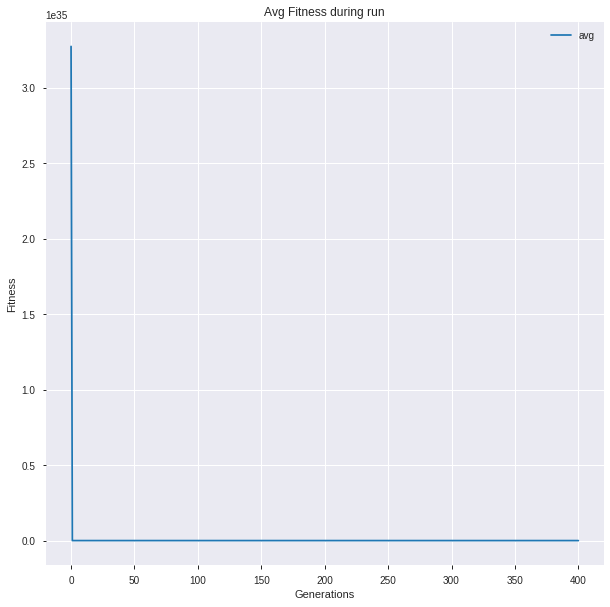

In [28]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
ax.plot(stats_df['gen'], [x[0] for x in stats_df['avg']], label='avg')
ax.set_title('Avg Fitness during run')
ax.set_xlabel('Generations')
ax.set_ylabel('Fitness')
ax.legend()
plt.show()

In [29]:
plt.close()

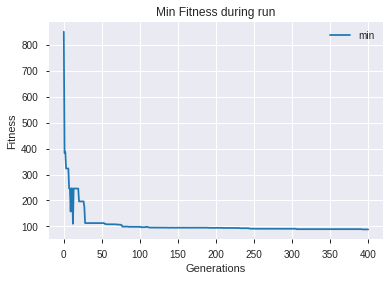

In [30]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(stats_df['gen'], [x[0] for x in stats_df['min']], label='min')
ax.set_title('Min Fitness during run')
ax.set_xlabel('Generations')
ax.set_ylabel('Fitness')
ax.legend()
plt.show()

In [31]:
plt.close()

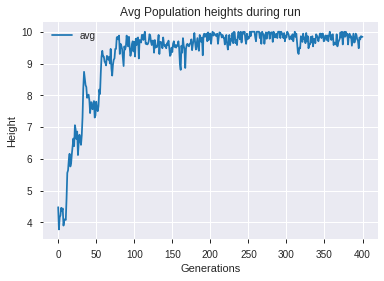

In [32]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(stats_df['gen'], [x[1] for x in stats_df['avg']], label='avg')
ax.set_title('Avg Population heights during run')
ax.set_xlabel('Generations')
ax.set_ylabel('Height')
ax.legend()
plt.show()

In [33]:
def predict(model, sample):
  func = toolbox.compile(model)
  func(*sample)
  

Finally we create the `predict` function to see the actual output of our evolve model.

In [34]:
best = hof[0]
print(predict(best, x_test[4]) , y_test[4])
print(predict(best, x_test[7]) , y_test[7])
print(predict(best, x_test[11]) , y_test[11])
print(predict(best, x_test[12]) , y_test[12])
print(predict(best, x_test[28]) , y_test[28])

None 22.8
None 51.4
None 30.7
None 35.6
None 41.0
